# Figure 6, literature sets

In this notebook, we'll generate an additional figure panel for Figure 6 which compares the top DEGs induced by dexamethasone to gene sets curated from the literature.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
tidyr: Additional tidy data functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(tidyr)
quiet_library(ggplot2)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_6"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

We'll also use this helper function from the `colorway` package:

In [3]:
values_to_colors <- function(x,
                             min_val = NULL,
                             max_val = NULL,
                             colorset = c("darkblue","dodgerblue","gray80","orange","orangered"),
                             missing_color = "black") {

  heat_colors <- grDevices::colorRampPalette(colorset)(1001)

  if (is.null(max_val)) {
    max_val <- max(x, na.rm = T)
  } else {
    x[x > max_val] <- max_val
  }
  if (is.null(min_val)) {
    min_val <- min(x, na.rm = T)
  } else {
    x[x < min_val] <- min_val
  }

  if (sum(x == min_val, na.rm = TRUE) == length(x)) {
    colors <- rep(heat_colors[1],length(x))
  } else {
    if (length(x) > 1) {
      if (stats::var(x, na.rm = TRUE) == 0) {
        colors <- rep(heat_colors[500], length(x))
      } else {
        heat_positions <- unlist(round((x - min_val) / (max_val - min_val) * 1000 + 1, 0))

        colors <- heat_colors[heat_positions]
      }
    } else {
      colors <- heat_colors[500]
    }
  }

  if (!is.null(missing_color)) {
    colors[is.na(colors)] <- grDevices::rgb(t(grDevices::col2rgb(missing_color)/255))
  }

  colors
}

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for DEG, Hallmark Pathway enrichment, and motif enrichment.

DEG: Differentially expressed genes

In [4]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [5]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



## Set up literature sets

In [6]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

In [7]:
gene_sets <- read.csv("../common/gene_sets/literature_drug_response.csv")
dex_sets <- gene_sets %>%
  filter(related_drug == "Dexamethasone") %>%
  mutate(experiment = sub("(_UP|_DN)$","", pathway),
         study = sub("^([A-Z]+_[0-9]+)_.+", "\\1", pathway))

In [8]:
unique(dex_sets$study)

[1] "JUBB_2016"       "CAO_2018"        "MCDOWELL_2018"   "PARK_2019"      
[5] "PENMARI_2020"    "ANSARI_2022"     "KATHIRIVEL_2022" "GO_0071549"

Drop the "Only" gene sets from Kathirivel, et al.

In [9]:
dex_sets <- dex_sets %>%
  filter(!grepl("KATHIRIVEL.+ONLY",pathway))

In [10]:
nrow(dex_sets)

[1] 19

Separate each gene for further analysis and plotting

In [11]:
dex_genes <- dex_sets %>%
  separate_rows(genes, sep = ";") %>%
  rename(gene = genes)

In [12]:
length(unique(dex_genes$gene))

[1] 1935

In [13]:
dex_up <- dex_genes %>%
  filter(direction == "up")
dex_dn <- dex_genes %>%
  filter(direction == "dn")

In [14]:
length(unique(dex_up$gene))
length(unique(dex_dn$gene))

[1] 1063

[1] 908

In [15]:
unique(intersect(unique(dex_up$gene), unique(dex_dn$gene)))

[1] "ARRDC3"   "CYTIP"    "DUSP4"    "GADD45B"  "GCLC"     "MET"     
 [7] "TSPAN2"   "BTBD11"   "SGK1"     "SRGAP3"   "PER2"     "RRAD"    
[13] "BIRC3"    "ANKRD1"   "C1orf116" "CHST7"    "IGFBP1"   "MFSD2A"  
[19] "SGPP2"    "TLE3"     "CLIP1"    "CLTCL1"   "IGSF10"   "MMP7"    
[25] "RASGEF1B" "AZGP1"    "LAMB1"    "FZD9"     "ST14"     ""        
[31] "H19"      "WISP1"    "LSP1"     "NR3C1"    "AQP1"     "GJB2"

Flag genes found in at least 2 different cell types

In [16]:
dex_genes <- dex_genes %>%
  group_by(gene) %>%
  mutate(common = length(unique(cell_type)) > 1,
         n_experiments = length(unique(experiment)),
         n_studies = length(unique(study)),
         n_up = sum(direction == "up"),
         n_dn = sum(direction == "dn")) %>%
  ungroup()

In [17]:
dex_genes %>%
  select(gene, direction, common) %>%
  unique() %>%
  group_by(direction, common) %>%
  summarise(n_common = n(), .groups = "keep")

direction,common,n_common
<chr>,<lgl>,<int>
dn,FALSE,778
dn,TRUE,130
up,FALSE,844
up,TRUE,219


In [18]:
common_dex_genes <- dex_genes %>%
  filter(common)
nrow(common_dex_genes)

[1] 774

## Load DEGs

In [19]:
fdr_cutoff <- 0.01

In [20]:
all_deg <- read.csv(deg_file)
all_deg <- all_deg %>%
  mutate(
      direction_sign = ifelse(
          is.na(logFC),
          sign(coef_D),
          sign(logFC)
      ),
      direction = ifelse(
          direction_sign == 1,
          "up", "dn"
      )
  )

In [21]:
dex_deg <- all_deg %>%
  filter(fg == "dexamethasone")

In [22]:
sig_dex_deg <- dex_deg %>%
  filter(adjP < fdr_cutoff)

In [23]:
length(unique(sig_dex_deg$gene))

[1] 1496

In [24]:
common_dex_deg <- dex_deg %>%
  filter(gene %in% common_dex_genes$gene)

In [25]:
length(unique(common_dex_deg$gene))

[1] 141

Filter the "common" set to include only genes that are also found in our dataset

In [26]:
common_dex_genes <- common_dex_genes %>%
  filter(gene %in% common_dex_deg$gene)

In [27]:
nrow(common_dex_genes)

[1] 361

In [28]:
length(unique(common_dex_deg$gene))

[1] 141

## Plot DEG sets

In this view, we'll plot all genes in the literature sets ranked by direction of expression and the number of literature sets that each gene is found in.

In [29]:
plot_dex_genes <- common_dex_genes %>%
  mutate(fill = ifelse(direction == "up", "darkred", "darkblue"))

experiment_xpos <- plot_dex_genes %>%
  select(experiment) %>%
  unique() %>%
  arrange(experiment) %>%
  mutate(x = -1 * n():1)

gene_ypos <- plot_dex_genes %>%
  select(gene, n_up, n_dn) %>%
  unique() %>%
  arrange(desc(n_dn), n_up) %>%
  mutate(y = 1:n())

plot_dex_genes <- plot_dex_genes %>%
  left_join(gene_ypos) %>%
  left_join(experiment_xpos)

Joining with `by = join_by(gene, n_up, n_dn)`
Joining with `by = join_by(experiment)`


In [30]:
table(common_dex_deg$timepoint)


  4  24 
600 609 

In [31]:
plot_deg_genes <- common_dex_deg %>%
  left_join(gene_ypos) %>%
  left_join(type_colors) %>%
  mutate(fill = values_to_colors(logFC, min_val = -1.5, max_val = 1.5)) %>%
  mutate(experiment = paste(cell_type_label, timepoint, "hr"))

deg_xpos <- plot_deg_genes %>%
  select(experiment, timepoint, cell_type_xpos) %>%
  unique() %>%
  arrange(timepoint, cell_type_xpos) %>%
  mutate(x = 1:n()) %>%
  mutate(x = ifelse(timepoint == 24, x + 1, x)) %>%
  select(experiment, x)

plot_deg_genes <- plot_deg_genes %>%
  left_join(deg_xpos)

experiment_xpos <- rbind(experiment_xpos, deg_xpos)

Joining with `by = join_by(gene)`
Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(experiment)`


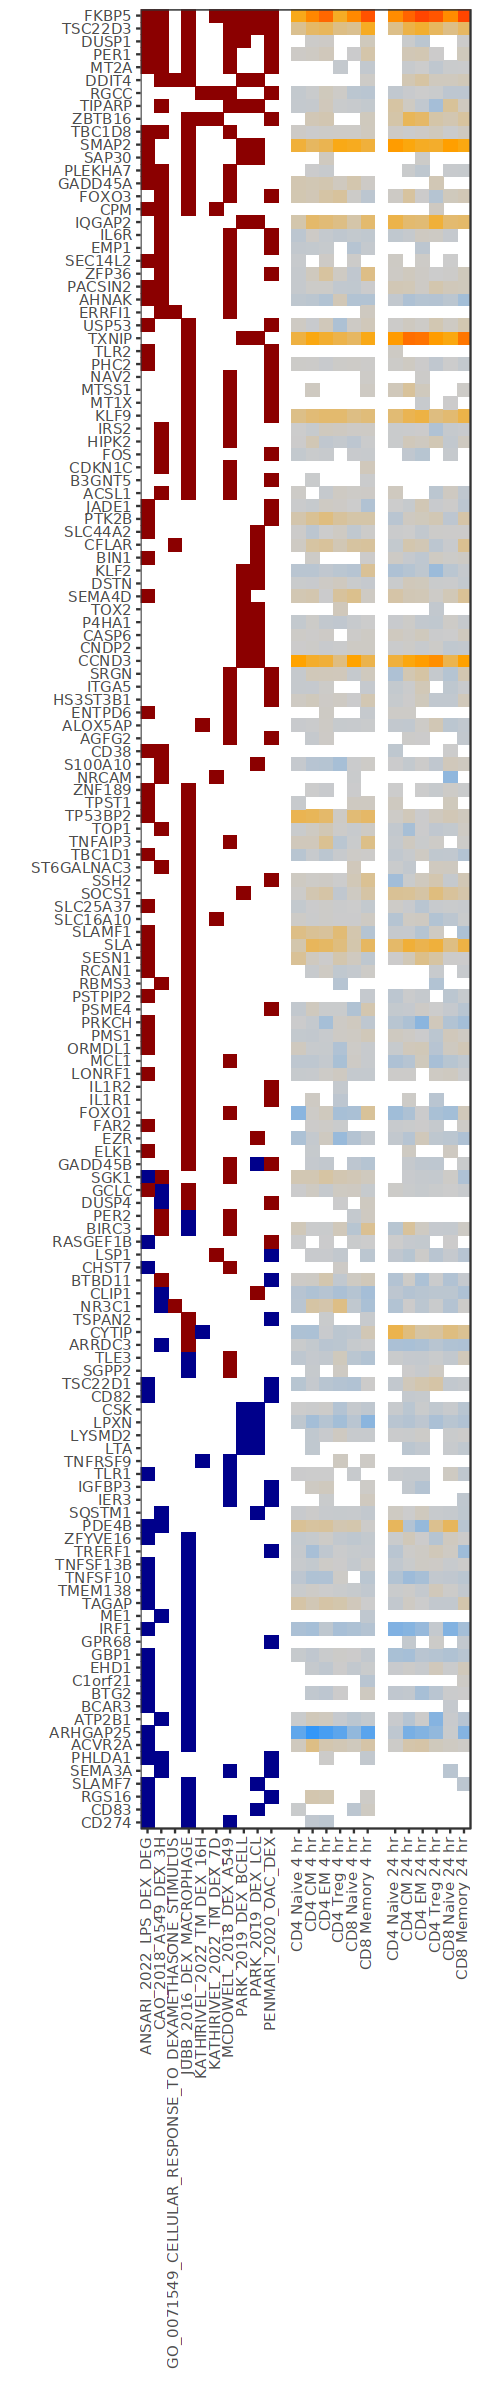

In [32]:
options(repr.plot.width = 4, repr.plot.height = 20)
ggplot() +
  geom_rect(
      data = plot_dex_genes,
      aes(xmin = x - 0.5, xmax = x + 0.5,
          ymin = y - 0.5, ymax = y + 0.5,
          fill = fill)
  ) +
  geom_rect(
      data = plot_deg_genes,
      aes(xmin = x - 0.5, xmax = x + 0.5,
          ymin = y - 0.5, ymax = y + 0.5,
          fill = fill)
  ) +
  scale_x_continuous(
      "",
      breaks = experiment_xpos$x,
      labels = experiment_xpos$experiment,
      expand = c(0,0)
  ) +
  scale_y_continuous(
      "",
      breaks = gene_ypos$y,
      labels = gene_ypos$gene,
      expand = c(0,0)
  ) +
  scale_fill_identity() +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.grid = element_blank())

## Significant DEGs only

The plot above is a bit too busy for a figure panel. We're really interested the differentially-expressed genes, so let's look at the top DEGs in each direction and see how well those are represented among the previously published gene sets.

To look at DEGs across cell types, we'll pull the top 10 per cell type and time point, and reduce that to a unique set across all comparisons.

In [33]:
top_sig_dex_deg <- sig_dex_deg %>%
  group_by(aifi_cell_type, timepoint, direction) %>%
  arrange(adjP) %>%
  slice(1:10) %>%
  ungroup()

In [34]:
nrow(top_sig_dex_deg)

[1] 236

In [35]:
length(unique(top_sig_dex_deg$gene))

[1] 87

In [36]:
length(unique(top_sig_dex_deg$gene[top_sig_dex_deg$direction == "up"]))

[1] 36

In [37]:
length(unique(top_sig_dex_deg$gene[top_sig_dex_deg$direction == "dn"]))

[1] 51

In [38]:
sig_gene_ypos <- top_sig_dex_deg %>%
  group_by(gene, direction) %>%
  summarise(n_up = sum(direction == "up"),
            n_dn = sum(direction == "dn"),
            max_logFC = logFC[abs(logFC) == max(abs(logFC))],
            .groups = "keep") %>%
  ungroup() %>%
  arrange(max_logFC) %>%
  mutate(y = 1:n())

In [39]:
plot_sig_dex_deg <- dex_deg %>%
  filter(gene %in% top_sig_dex_deg$gene) %>%
  left_join(sig_gene_ypos) %>%
  left_join(type_colors) %>%
  mutate(experiment = paste(cell_type_label, timepoint, "hr")) %>%
  left_join(deg_xpos) %>%
  mutate(logFC = ifelse(direction == "up" & is.na(logFC), 1.5, logFC)) %>%
  mutate(fill = values_to_colors(logFC, colorset = c("darkblue","white","darkred"), min_val = -1.2, max_val = 1.2))

Joining with `by = join_by(gene, direction)`
Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(experiment)`


In [40]:
out_dex_deg <- file.path(out_dir, paste0("dexamethasone_top_deg_data_", Sys.Date(), ".csv"))
write.csv(
    plot_sig_dex_deg,
    out_dex_deg,
    quote = FALSE,
    row.names = FALSE
)

In [41]:
sig_points <- plot_sig_dex_deg %>%
  filter(adjP < 0.05)

Previously observed genes

In [42]:
prev_dex_genes <- dex_genes %>%
  mutate(fill = ifelse(direction == "up", "darkred", "darkblue")) %>%
  select(-direction,-n_up, -n_dn) %>%
  left_join(sig_gene_ypos) %>%
  left_join(experiment_xpos) %>%
  filter(!is.na(y))

Joining with `by = join_by(gene)`
Joining with `by = join_by(experiment)`


In [43]:
out_dex_lit <- file.path(out_dir, paste0("dexamethasone_top_deg_in_lit_data_", Sys.Date(), ".csv"))
write.csv(
    prev_dex_genes,
    out_dex_lit,
    quote = FALSE,
    row.names = FALSE
)

In [44]:
nrow(prev_dex_genes)

[1] 46

In [45]:
all_deg_tiles <- expand.grid(
    x = unique(plot_sig_dex_deg$x),
    y = unique(plot_sig_dex_deg$y)
)
missing_deg_tiles <- all_deg_tiles %>%
  filter(!paste(x, y) %in% paste(plot_sig_dex_deg$x, plot_sig_dex_deg$y))

In [46]:
all_lit_tiles <- expand.grid(
    x = unique(prev_dex_genes$x),
    y = unique(plot_sig_dex_deg$y)
)
missing_lit_tiles <- all_lit_tiles %>%
  filter(!paste(x, y) %in% paste(prev_dex_genes$x, prev_dex_genes$y))

Warning message:
“Removed 10 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 69 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


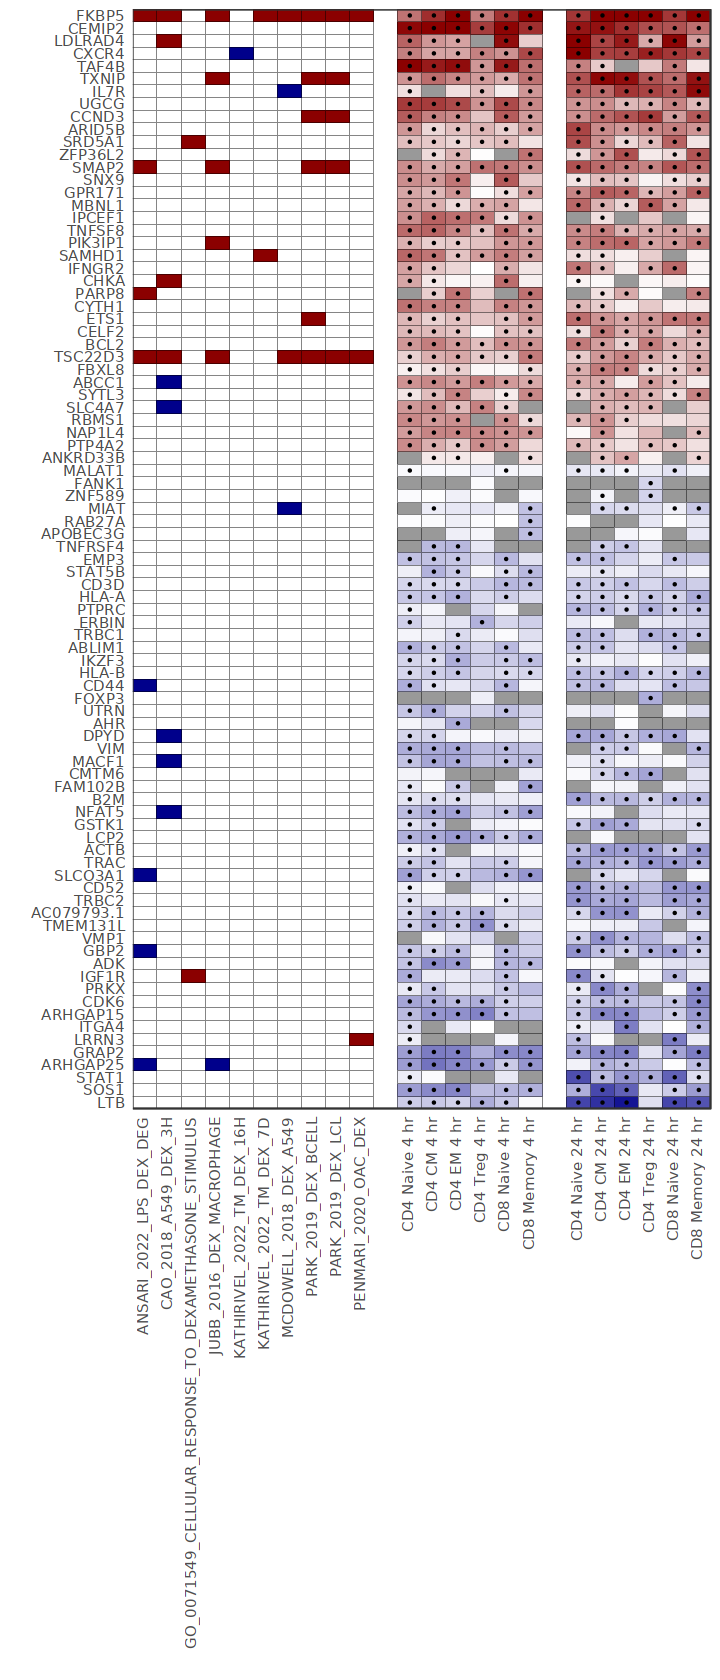

In [47]:
options(repr.plot.width = 6, repr.plot.height = 14)
p <- ggplot() +
  geom_rect(
      data = missing_lit_tiles,
      aes(xmin = x - 0.5, xmax = x + 0.5,
          ymin = y - 0.5, ymax = y + 0.5),
      fill = "white",
      color = "black",
      linewidth = 0.1
  ) +
  geom_rect(
      data = prev_dex_genes,
      aes(xmin = x - 0.5, xmax = x + 0.5,
          ymin = y - 0.5, ymax = y + 0.5,
          fill = fill),
      color = "black",
      linewidth = 0.1
  ) +
  geom_rect(
      data = missing_deg_tiles,
      aes(xmin = x - 0.5, xmax = x + 0.5,
          ymin = y - 0.5, ymax = y + 0.5),
      color = "black",
      linewidth = 0.1,
      fill = "gray60"
  ) +
  geom_rect(
      data = plot_sig_dex_deg,
      aes(xmin = x - 0.5, xmax = x + 0.5,
          ymin = y - 0.5, ymax = y + 0.5,
          fill = fill),
      color = "black",
      linewidth = 0.1
  ) +
  geom_point(
      data = sig_points,
      aes(x = x, y = y),
      color = "black",
      size = 0.2
  ) +
  scale_x_continuous(
      "",
      breaks = experiment_xpos$x,
      labels = experiment_xpos$experiment,
      expand = c(0,0)
  ) +
  scale_y_continuous(
      "",
      breaks = sig_gene_ypos$y,
      labels = sig_gene_ypos$gene,
      expand = c(0,0)
  ) +
  scale_fill_identity() +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.grid = element_blank(),
        axis.ticks = element_blank())
p

In [48]:
out_plot <- file.path(
    out_dir,
    paste0("dexamethasone_top_deg_in_lit_heatmap_",Sys.Date(),".pdf")
)
ggsave(out_plot,
       p,
       width = 6, height = 18)

Warning message:
“Removed 10 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 69 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [49]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Figure 6 Lit. Sets", Sys.Date())

In [50]:
out_list <- list(out_dex_deg, out_dex_lit, out_plot)

In [51]:
out_list

[[1]]
[1] "output/figure_6/dexamethasone_top_deg_data_2023-10-24.csv"

[[2]]
[1] "output/figure_6/dexamethasone_top_deg_in_lit_data_2023-10-24.csv"

[[3]]
[1] "output/figure_6/dexamethasone_top_deg_in_lit_heatmap_2023-10-24.pdf"

In [52]:
in_list <- c(deg_uuid)

In [53]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/repro-vrd-tea-seq/figures/Fig-6_dex_literature_sets.ipynb"
[1] "2) /home/jupyter/examples/R/XX-R Tips and tricks.ipynb"
[1] "3) /home/jupyter/examples/R/SDK/upload_files_r.ipynb"


Please select (1-3)  1


$files
$files[[1]]
[1] "output/figure_6/dexamethasone_top_deg_data_2023-10-24.csv"

$files[[2]]
[1] "output/figure_6/dexamethasone_top_deg_in_lit_data_2023-10-24.csv"

$files[[3]]
[1] "output/figure_6/dexamethasone_top_deg_in_lit_heatmap_2023-10-24.pdf"


$traceId
[1] "3a83d974-685d-4af5-92a8-6f37fb589711"

In [54]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggplot2_3.4.3 tidyr_1.3.0   dplyr_1.1.3   purrr_1.0.2  
[6] hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     bitops_1.0-7      assertthat_0.2.1 
 [9] textshaping_0.3.6 